## 1. Классификация вершин (10 баллов) 

Будем решать задачу предсказания влиятельности вершин как задачу классификации. Разобьем отрезок $\left [ s_{i}^{min},s_{i}^{max}\right ]$ на $k$ одинаковых отрезков, и разметим вершины, чьи значения $s_{i}$ лежит в $\left[s_i^{(j-1)},s_i^{(j)} \right)$, $j = 1, 2 \dots k$, меткой $j$, т.е. значение класса $l_i$ для $i$-ой вершины определяется: 

$$
l_i=\left [k \frac{s_i-s_i^{min}}{s_i^{max}-s_i^{min}}\right]. 
$$

Для k=2 задача превращается в задачу бинарной классификации. 

1. Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core

2.  Исследуйте корреляцию между признаками и целевой переменой 

3. Разделите выборку на обучающую и тестовую, постройте модели классификации (бинарной), выведите метрики качества, подберите оптимальные гиперпараметры

4. Проанализируйте важность признаков 

In [ ]:
import networkx as nx
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### #1

In [ ]:
G=nx.read_edgelist('ca-GrQc.mtx') 
print('Nodes:',G.number_of_nodes()) 
print('Edges:',G.number_of_edges())
print('Density:',nx.density(G)) 

Nodes: 4158
Edges: 13422
Density: 0.0015530402828935425


In [ ]:
df = pd.read_csv('spreading_data_ca-GrQc.csv')
k=2 
s=list(df['spreading ability'])
l=[]
for v in s: 
    t=k*(v-df['spreading ability'].min())//(df['spreading ability'].max()-df['spreading ability'].min())
    if (t==k):
        t=k-1
    l.append(t)

df['target'] = l
df = df.drop('spreading ability', axis=1)
df

,node,target
0,19,1.0
1,1,1.0
2,1751,1.0
3,2408,0.0
4,3078,1.0
...,...,...
4153,3858,1.0
4154,3859,1.0
4155,4019,1.0
4156,4124,0.0


In [ ]:
df['clust'] = (nx.clustering(G).values())
df['dcent'] = nx.degree_centrality(G).values()
df['ecent'] = nx.eigenvector_centrality(G).values()
df['ccent'] = nx.closeness_centrality(G).values()
df['bcent'] = nx.betweenness_centrality(G).values()

In [ ]:
df = df.drop(['node'],axis=1)

In [ ]:
df

,target,clust,dcent,ecent,ccent,bcent
0,1.0,0.500000,0.000962,1.978526e-07,0.184101,0.002893
1,1.0,0.333333,0.001443,1.930278e-08,0.159047,0.002290
2,1.0,1.000000,0.000722,1.893130e-08,0.158980,0.000000
3,0.0,0.400000,0.001203,5.769050e-07,0.171225,0.001707
4,1.0,0.333333,0.000722,1.450752e-08,0.146260,0.000481
...,...,...,...,...,...,...
4153,1.0,0.000000,0.000241,2.516598e-08,0.147349,0.000000
4154,1.0,1.000000,0.000481,6.328154e-07,0.180261,0.000000
4155,1.0,0.000000,0.000241,9.752772e-07,0.168655,0.000000
4156,0.0,0.000000,0.000241,2.715108e-08,0.150550,0.000000


### #2

In [ ]:
df.corr()

,target,clust,dcent,ecent,ccent,bcent
target,1.000000,-0.013769,0.005637,0.014643,0.012798,0.011934
clust,-0.013769,1.000000,0.051331,0.055931,-0.117046,-0.284538
dcent,0.005637,0.051331,1.000000,0.600507,0.435221,0.488306
ecent,0.014643,0.055931,0.600507,1.000000,0.275792,0.135088
ccent,0.012798,-0.117046,0.435221,0.275792,1.000000,0.473812
bcent,0.011934,-0.284538,0.488306,0.135088,0.473812,1.000000


Корреляция между таргетом и признаками не наблюдается

### #3

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=13)
X_train.shape, X_test.shape

((3118, 5), (1040, 5))

Text(0, 0.5, 'True Positive Rate')

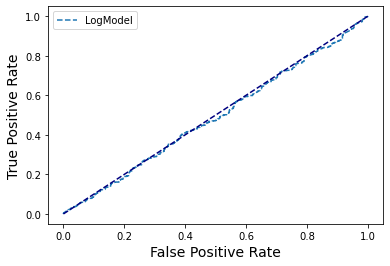

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate':('constant', 'optimal'), 'max_iter':[1000, 2000]}
from sklearn.linear_model import SGDClassifier 
sdg = SGDClassifier(loss = 'log', eta0=0.1, alpha=0.1, random_state=13 )
grid = GridSearchCV(sdg, parameters)
grid.fit(X_train,y_train)
grid.get_params()
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:,1])
auc(fpr, tpr)
plt.plot(fpr, tpr, '--',label='LogModel')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.legend()
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

Логистическая регрессия в данном случае показывает результат не лучше, чем если бы мы присваивали бы вершине класс случайно

## 2. Предсказание связей (10 баллов)

1. Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована). 

2. Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC? 

3. Постройте модель классификации, используя структурные признаки, улучшилось ли качество предсказания?

4. Постройте модель предскзания на основе вложения (используйте вложение сети с помощью Лапласиана или Node2vec, на выбор) Сравните качество предсказания для разных размерностей используемого пространства $d$. 



### #1

In [ ]:
G=nx.read_edgelist('email-Eu-core.txt', delimiter=' ', nodetype= int) 
G = G.to_undirected()
print('Nodes:',G.number_of_nodes()) 
print('Edges:',G.number_of_edges())
print('Density:',nx.density(G)) 

Nodes: 1005
Edges: 16706
Density: 0.03311331787278746


In [ ]:
edge_subset = random.sample(G.edges(), int(0.25 * G.number_of_edges()))

G_train = G.copy()
G_train.remove_edges_from(edge_subset)

### #2

Коэффициент Жаккара

In [ ]:
prediction_jaccard = list(nx.jaccard_coefficient(G_train))
scores, y = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_jaccard]) 

In [ ]:
fpr, tpr, thresholds = roc_curve(y, scores)
auc(fpr, tpr)

0.9239495756911261

Коэффициент Адамика-Адара

In [ ]:
prediction_adar = list(nx.adamic_adar_index(G_train))
scoresad, yad = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_adar]) 

In [ ]:
ad, tad, thresholds = roc_curve(yad, scoresad)
auc(ad, tad)

0.9390904942094045

Коэффициент предпочтительного присоединения

In [ ]:
prediction_pref = list(nx.preferential_attachment(G_train))
scorespref, ypref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_pref]) 

In [ ]:
pref, tpref, thresholds = roc_curve(ypref, scorespref)
auc(pref, tpref)

0.8652338937830562

Text(0, 0.5, 'True Positive Rate')

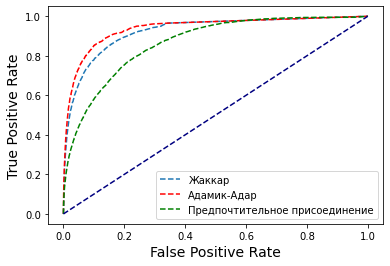

In [ ]:
plt.plot(fpr, tpr, '--',label='Жаккар')
plt.plot(ad, tad, '--', color="r",label='Адамик-Адар')
plt.plot(pref, tpref, '--', color="g",label='Предпочтительное присоединение')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.legend()
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

Лучший результат показывает метод Адамика-Адара

### #3

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression()
X = list(zip(scores,scoresad,scorespref))
clf.fit(X,y)
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1])
auc(fpr, tpr)

0.9182628576583056

Text(0, 0.5, 'True Positive Rate')

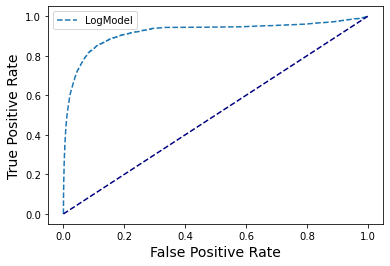

In [ ]:
plt.plot(fpr, tpr, '--',label='LogModel')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.legend()
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

Логистическая модель с 3 структурными признаками показала результат близкий к коэффициенту Жаккара

### #4

In [ ]:
from sklearn.manifold import spectral_embedding

a=nx.to_numpy_array(G_train)
emb = []
for i in range(2,33):
    emb.append(spectral_embedding(a, n_components=i,norm_laplacian=True, random_state=0))
#X_transformed = emb.fit_transform(G_train)
emb

/Users/borisminasenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


[array([[-1.52005696e-04,  3.81955609e-03],
        [-1.42025408e-03,  3.21497459e-03],
        [-3.09242708e-03, -9.74815573e-03],
        ...,
        [-7.00637700e-19,  1.09743555e-18],
        [-2.26569181e-03, -1.38952667e-03],
        [-4.05738537e-03, -1.26436593e-02]]),
 array([[-1.52005696e-04,  3.81955609e-03, -4.56129664e-03],
        [-1.42025408e-03,  3.21497459e-03, -4.84797830e-03],
        [-3.09242708e-03, -9.74815573e-03,  8.69995643e-03],
        ...,
        [-4.85313730e-19,  1.12510875e-18, -6.03456315e-19],
        [-2.26569181e-03, -1.38952667e-03, -2.75175108e-04],
        [-4.05738537e-03, -1.26436593e-02,  1.18997020e-02]]),
 array([[-1.52005696e-04,  3.81955609e-03, -4.56129664e-03,
          3.40511860e-03],
        [-1.42025408e-03,  3.21497459e-03, -4.84797830e-03,
          1.35741651e-03],
        [-3.09242708e-03, -9.74815573e-03,  8.69995643e-03,
          1.00326372e-02],
        ...,
        [-8.34374551e-19,  1.26596797e-18,  4.39838849e-21,
      

## 3. Задача кластеризации (10 баллов)

 Каждый сотдрудник относится к одному из департаментов, которые и являются истинными сообществами в сети. 

1. Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем? 

2. Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества от числа задаваемых сообществ. 
Какое разбиение оказывается более близким к истинному? 

3. Выполните пункт 2) для алгоритма Гирвана-Ньюмана. Сравните качество агломеративного метода и Гирвана-Ньюмана. 

In [ ]:
G = nx.read_edgelist('email-Eu-core.txt')
df = pd.read_csv('email-Eu-core-department-labels.txt', sep=' ', names=['node', 'label'])

### #1

Доля вершин в наибольшем сообществе 0.10845771144278607
Доля вершин в наименьшем сообществе 0.0009950248756218905


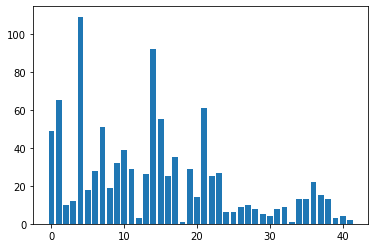

In [ ]:
plt.bar(df['label'].value_counts().index.values, df['label'].value_counts())
b = max(df['label'].value_counts()) / len(df)
m = min(df['label'].value_counts()) / len(df)

print("Доля вершин в наибольшем сообществе", b)
print("Доля вершин в наименьшем сообществе", m)

### #2

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score

def similarity_matrix(G, nodelist=None): # nodelist задает порядок строк в матрице
    if (nodelist is None):
        nodelist=list(G.nodes)

    Smatrix=np.zeros((len(nodelist), len(nodelist)))

    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i+1:], start = i+1):
            Smatrix[i,j]=(len(set(G[node1]) & set(G[node2])) + int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])
                                                                                          +1-int(G.has_edge(node1,node2)))
            Smatrix[j,i]=Smatrix[i,j]

    return Smatrix

In [ ]:
com = []
for i in range(2,50,4):
    communities = AgglomerativeClustering(linkage='average', n_clusters = i)
    X=similarity_matrix(G,nodelist=None)
    communities.fit(X)
    com.append(normalized_mutual_info_score(df['label'].values.astype('int'), communities.labels_))  

/Users/borisminasenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:492: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/Users/borisminasenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:492: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/Users/borisminasenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:492: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/Users/borisminasenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglome

In [ ]:
com

[0.002300736638791333,
 0.04629470811257215,
 0.17021925143717995,
 0.17428235477537765,
 0.24411897717177758,
 0.30907030575151395,
 0.38693957293683845,
 0.4245369170085096,
 0.44066074633878183,
 0.49747853853279894,
 0.5030225661441611,
 0.5108568575557129]

Разбиение оказывается более близким к истинному при увелечении кол-ва кластеров